In [1]:
# number of neurons in the hidden layer
hidden_dim = 100

# learning rate
learning_rate = 0.005

# number of training epochs
n_epochs = 10

In [2]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt

path = 'mnist-permutated-png-format/mnist'
train_paths = []
val_paths = []
test_paths = []
for i in range(10):
    trp = os.listdir(path+'/train/'+str(i))
    for trpath in trp:
        train_paths = train_paths + [path+'/train/'+str(i)+'/'+trpath]
    vap = os.listdir(path+'/val/'+str(i))
    for vapath in vap:
        val_paths = val_paths + [path+'/val/'+str(i)+'/'+vapath]
    tep = os.listdir(path+'/test/'+str(i))
    for tepath in tep:
        test_paths = test_paths + [path+'/test/'+str(i)+'/'+tepath]
print(train_paths[0:5])

['mnist-permutated-png-format/mnist/train/0/0-img-1-lbl0.png', 'mnist-permutated-png-format/mnist/train/0/0-img-10005-lbl0.png', 'mnist-permutated-png-format/mnist/train/0/0-img-10010-lbl0.png', 'mnist-permutated-png-format/mnist/train/0/0-img-10025-lbl0.png', 'mnist-permutated-png-format/mnist/train/0/0-img-10069-lbl0.png']


In [3]:
n = len(train_paths)
train_images = np.zeros((n, 28*28), dtype=np.int)
train_labels = np.zeros(n, dtype=np.int)
for i in range(n):
    ip = train_paths[i]
    image = Image.open(ip).convert('L')
    npimage = np.array(image).reshape(28*28)
    train_images[i,:] = npimage
    train_labels[i] = ip[-5]
    
n = len(val_paths)
val_images = np.zeros((n, 28*28), dtype=np.int)
val_labels = np.zeros(n, dtype=np.int)
for i in range(n):
    ip = val_paths[i]
    image = Image.open(ip).convert('L')
    npimage = np.array(image).reshape(28*28)
    val_images[i,:] = npimage
    val_labels[i] = ip[-5]
    
n = len(test_paths)
test_images = np.zeros((n, 28*28), dtype=np.int)
test_labels = np.zeros(n, dtype=np.int)
for i in range(n):
    ip = test_paths[i]
    image = Image.open(ip).convert('L')
    npimage = np.array(image).reshape(28*28)
    test_images[i,:] = npimage
    test_labels[i] = ip[-5]
    
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)

(40200, 784) (40200,)
(19800, 784) (19800,)
(10000, 784) (10000,)


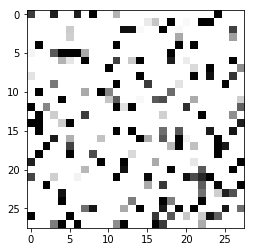

In [4]:
plt.imshow(train_images[0].reshape(28,28), cmap='gray')

In [5]:
for i in range(10):
    print(i, sum(train_labels==i))

0 3937
1 4494
2 4019
3 4183
4 3937
5 3618
6 3920
7 4236
8 3880
9 3976


In [6]:
class DigitDataset(Dataset):
    def __init__(self, features, labels):
        super(DigitDataset, self).__init__()
        self.features = features
        self.labels = labels
        self.transforms = transforms.Compose([transforms.ToTensor()])
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        image = self.features[index,:]
        image = image.reshape(28,28,1)
        image = self.transforms(image)
        image = image.float()
        label = self.labels[index]
        label = label.astype(np.int64)
        return (image, label)

train_dataset = DigitDataset(train_images, train_labels)
val_dataset = DigitDataset(val_images, val_labels)
test_dataset = DigitDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.main = nn.Sequential(nn.Linear(28*28, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, 10))
    
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.main(out)
        return out

In [8]:
model = MLPModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
def train():
    model.train()
    train_loss = 0
    for iteration, (images, labels) in enumerate(train_loader):
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = train_loss / len(train_loader)
    return average_loss

def validation():
    model.eval()
    val_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = model(images)
            loss = loss_fn(output, labels)
            val_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()
            
    accuracy = 100.0 * n_correct / len(val_loader.dataset)
    average_loss = val_loss / len(val_loader)
    return val_loss, accuracy

def test():
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()
            
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    average_loss = test_loss / len(test_loader)
    return test_loss, accuracy

In [10]:
train_losses = []
val_losses = []
val_accuracy = []
for epoch in range(n_epochs):
    train_loss = train()
    train_losses.append(train_loss)
    val_loss, accuracy = validation()
    val_losses.append(val_loss)
    val_accuracy.append(accuracy)
    print('Epoch {}, Training loss: {:.4f}, Validation loss: {:.4f}, Validation accuracy: {:.1f}%'.format(epoch+1, train_loss, val_loss, accuracy))

Epoch 1, Training loss: 312.7353, Validation loss: 713.9945, Validation accuracy: 10.0%
Epoch 2, Training loss: 2.3030, Validation loss: 713.6972, Validation accuracy: 11.4%
Epoch 3, Training loss: 2.3021, Validation loss: 713.5551, Validation accuracy: 11.4%
Epoch 4, Training loss: 2.3016, Validation loss: 713.4930, Validation accuracy: 11.4%
Epoch 5, Training loss: 2.3014, Validation loss: 713.4702, Validation accuracy: 11.4%
Epoch 6, Training loss: 2.3012, Validation loss: 713.4628, Validation accuracy: 11.4%
Epoch 7, Training loss: 2.3011, Validation loss: 713.4652, Validation accuracy: 11.4%
Epoch 8, Training loss: 2.3011, Validation loss: 713.4680, Validation accuracy: 11.4%
Epoch 9, Training loss: 2.3011, Validation loss: 713.4739, Validation accuracy: 11.4%
Epoch 10, Training loss: 2.3011, Validation loss: 713.4796, Validation accuracy: 11.4%


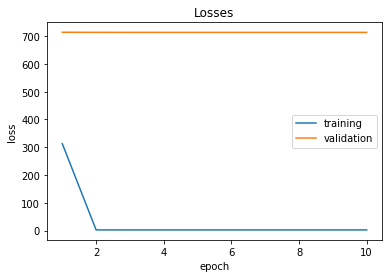

In [11]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.plot(np.arange(1, n_epochs+1), train_losses)
plt.plot(np.arange(1, n_epochs+1), val_losses)
plt.legend(['training', 'validation'])

In [ ]:
test_loss, accuracy = test()
print('Test loss: {:.4f}, accuracy: {:.1f}%'.format(test_loss, accuracy))